In [23]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import deque, defaultdict
from linearApprox import *
from collections import deque

In [ ]:
def run_n_step_sarsa_linear(
    initialEdges, goalEdges, totalSteps, nLookahead,
    epsilon, gamma, alpha, pGen, pSwap, maxAge,
    edr_window_size=100, convergence_epsilon=0.001, plot=False,
    softmax=False, temperature=1.0, temperature_decay=1.0,
    reward_mode="basic", reward_alpha=1, reward_epsilon=0.001
):
    def select_action(state, temperature, epsilon, softmax):
        features = featurize_state(state, goal_order=goalEdges)
        possible_actions = getPossibleActions(state[0], goalEdges)
        if softmax:
            q_vals = [Q.get_q_value(features, a) for a in possible_actions]
            probs = softmax_probs(q_vals, temperature)
            return random.choices(possible_actions, weights=probs)[0]
        else:
            return random.choice(possible_actions) if random.random() < epsilon else max(
                possible_actions, key=lambda a: Q.get_q_value(features, a)
            )

    feature_size = len(initialEdges) + len(goalEdges)
    Q = LinearQApproximator(feature_size=feature_size)
    q_value_diffs = []
    q_value_diffs_per_goal = {goal: [] for goal in goalEdges}

    goal_success_queues = {goal: deque(maxlen=edr_window_size) for goal in goalEdges}
    raw_state = [(edge, -1) for edge in initialEdges]
    rolling_edrs = {goal: 0.0 for goal in goalEdges}
    current_state = get_augmented_state(raw_state, rolling_edrs, goal_order=goalEdges)

    action = select_action(current_state, temperature, epsilon, softmax)
    state_buffer = deque([current_state], maxlen=nLookahead + 1)
    action_buffer = deque([action], maxlen=nLookahead + 1)
    reward_buffer = deque([], maxlen=nLookahead)

    for t in range(totalSteps):
        prev_state = state_buffer[-1]
        prev_action = action_buffer[-1]

        next_state = performAction(prev_action, prev_state)
        next_state = ageEntanglements(next_state, maxAge)
        next_state = generateEntanglement(next_state, pGen)

        consumed_edges, goal = prev_action
        success = False
        if goal is not None and consumed_edges:
            success_prob = pSwap ** (len(consumed_edges) - 1)
            success = random.random() < success_prob
        reward = compute_reward(
            action=prev_action,
            goal_success_queues=goal_success_queues,
            total_timesteps=t + 1,
            pSwap=pSwap,
            mode=reward_mode,
            alpha=reward_alpha,
            epsilon=reward_epsilon,
            success=success
        )
        
        reward_buffer.append(reward)

        edr_snapshot = {
            g: sum(goal_success_queues[g]) / max(1, len(goal_success_queues[g]))
            for g in goalEdges
        }
        next_state = get_augmented_state(next_state[0], edr_snapshot, goal_order=goalEdges)
        state_buffer.append(next_state)
        next_action = select_action(next_state, temperature, epsilon, softmax)
        action_buffer.append(next_action)

        if t >= nLookahead:
            G = sum((gamma ** i) * reward_buffer[i] for i in range(nLookahead))
            s_tau = state_buffer[0]
            a_tau = action_buffer[0]
            s_next = state_buffer[-1]
            a_next = action_buffer[-1]
            G += (gamma ** nLookahead) * Q.get_q_value(featurize_state(s_next, goalEdges), a_next)
            features_tau = featurize_state(s_tau, goal_order=goalEdges)
            current_q = Q.get_q_value(features_tau, a_tau)
            q_diff = abs(G - current_q)
            q_value_diffs.append(q_diff)

            for g in goalEdges:
                if g == a_tau[1] and a_tau[0]:
                    q_value_diffs_per_goal[g].append(q_diff)
                else:
                    q_value_diffs_per_goal[g].append(np.nan)

            Q.update(features_tau, a_tau, G, alpha)

        if softmax and temperature_decay < 1.0 and t % 10000 == 0:
            temperature = max(0.1, temperature * temperature_decay)

    # Final backups
    T = len(reward_buffer)
    for t_rem in range(T):
        n = T - t_rem
        G = sum((gamma ** i) * reward_buffer[t_rem + i] for i in range(n))
        s_tau = state_buffer[t_rem]
        a_tau = action_buffer[t_rem]
        s_next = state_buffer[-1]
        a_next = action_buffer[-1]
        G += (gamma ** n) * Q.get_q_value(featurize_state(s_next, goal_order=goalEdges), a_next)
        features_tau = featurize_state(s_tau, goal_order=goalEdges)
        current_q = Q.get_q_value(features_tau, a_tau)
        q_diff = abs(G - current_q)
        q_value_diffs.append(q_diff)

        for g in goalEdges:
            if g == a_tau[1] and a_tau[0]:
                q_value_diffs_per_goal[g].append(q_diff)
            else:
                q_value_diffs_per_goal[g].append(np.nan)

        Q.update(features_tau, a_tau, G, alpha)

    return q_value_diffs, q_value_diffs_per_goal, Q



def train_sarsa_linear_policy(
    edges, goal_edges, p_swap, p_gen, max_age,
    seed=0, plot_q_convergence=False, **kwargs
):
    random.seed(seed)
    np.random.seed(seed)

    # Extract hyperparameters with defaults
    alpha = kwargs.get("alpha", 0.01)
    gamma = kwargs.get("gamma", 0.99)
    epsilon = kwargs.get("epsilon", 0.05)
    totalSteps = kwargs.get("totalSteps", 10000)
    nLookahead = kwargs.get("nLookahead", 5)
    edr_window_size = kwargs.get("edr_window_size", 100)
    softmax = kwargs.get("softmax", False)
    temperature = kwargs.get("temperature", 1.0)
    temperature_decay = kwargs.get("temperature_decay", 1.0)

    reward_mode = kwargs.get("reward_mode", 'basic')
    reward_alpha = kwargs.get("reward_alpha", 1)
    reward_epsilon = kwargs.get("reward_epsilon", 0.001)

    # Train with n-step SARSA
    q_value_diffs, q_diffs_per_goal, Q = run_n_step_sarsa_linear(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        pGen=p_gen,
        pSwap=p_swap,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        softmax=softmax,
        temperature=temperature,
        temperature_decay=temperature_decay,
        reward_mode=reward_mode,
        reward_alpha=reward_alpha,
        reward_epsilon=reward_epsilon,
    )
    
    if plot_q_convergence:
        plot_q_value_convergence(q_value_diffs, q_diffs_per_goal)
    return Q




# **Plotting Code Below**

SPARSE

→ Basic (Log, Full) | pSwap = 0.1

=== Basic (Log, Full) | pSwap=0.1 Policy Training Run 1 ===

Average Aged-Out Entanglement Ratio: 0.3919

=== Mean EDRs After Burn-In ===
Goal (0, 6): 0.0000
Goal (0, 4): 0.0026
Mean Jain's Index (after burn-in): 0.1084

Average Aged-Out Entanglement Ratio: 0.3945

=== Mean EDRs After Burn-In ===
Goal (0, 6): 0.0000
Goal (0, 4): 0.0030
Mean Jain's Index (after burn-in): 0.1343

Average Aged-Out Entanglement Ratio: 0.3937

=== Mean EDRs After Burn-In ===
Goal (0, 6): 0.0000
Goal (0, 4): 0.0025
Mean Jain's Index (after burn-in): 0.1225

=== Basic (Log, Full) | pSwap=0.1 Policy Training Run 2 ===


KeyboardInterrupt: 

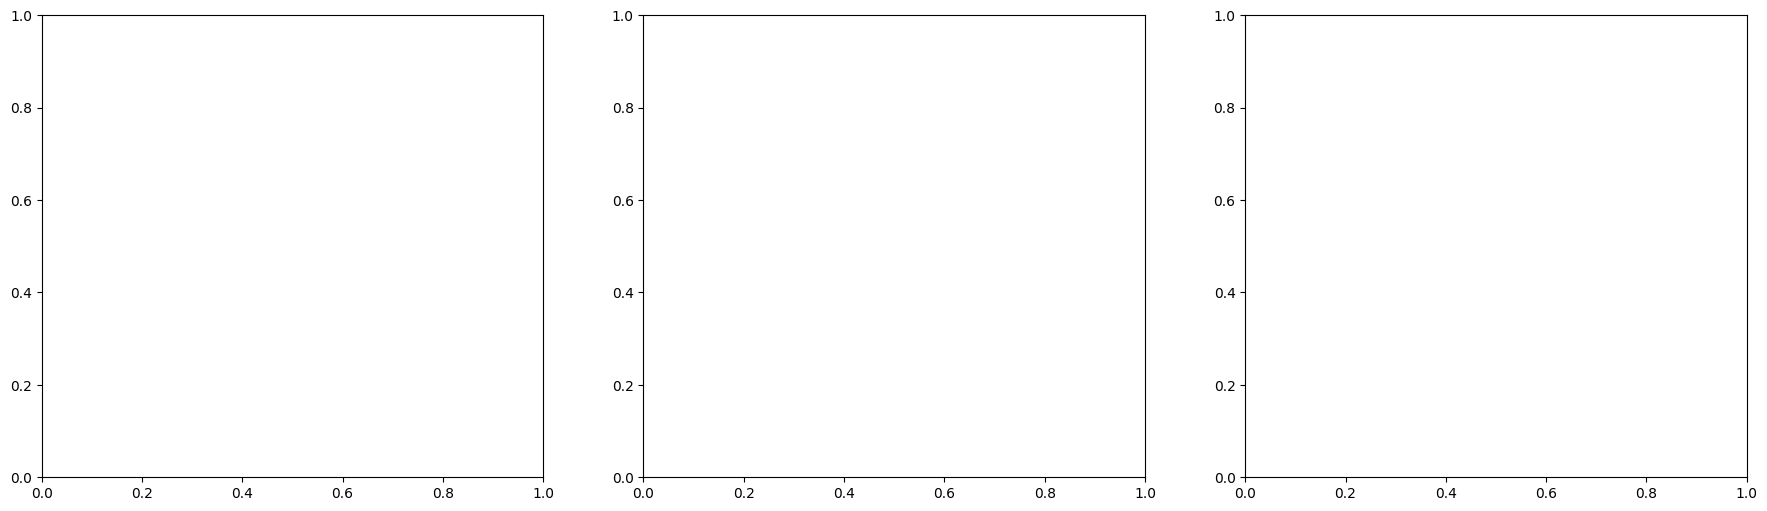

In [ ]:

def compare_reward_modes_across_param_full(
    policy_train_fn,
    reward_modes,
    mode_labels,
    param_name,
    param_values,
    edges,
    goal_edges,
    p_gen,
    p_swap,
    max_age,
    num_runs,
    num_steps,
    num_simulations,
    base_train_kwargs,
    validate_kwargs={}
):
    assert param_name in ['pGen', 'pSwap'], "param_name must be either 'pGen' or 'pSwap'"
    
    color_map = plt.get_cmap("tab10")
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))
    ax_jain, ax_tp, ax_pareto = axs

    for i, mode in enumerate(reward_modes):
        avg_jains = []
        avg_throughputs = []

        for param_val in param_values:
            curr_p_gen = param_val if param_name == 'pGen' else p_gen
            curr_p_swap = param_val if param_name == 'pSwap' else p_swap

            train_kwargs = base_train_kwargs.copy()
            train_kwargs['reward_mode'] = mode

            print(f"\n→ {mode_labels[i]} | {param_name} = {param_val}")
            results = run_policy_experiments(
                train_policy_fn=policy_train_fn,
                policy_name=f"{mode_labels[i]} | {param_name}={param_val}",
                edges=edges,
                goal_edges=goal_edges,
                p_gen=curr_p_gen,
                p_swap=curr_p_swap,
                max_age=max_age,
                num_runs=num_runs,
                num_steps=num_steps,
                num_simulations=num_simulations,
                train_kwargs=train_kwargs,
                validate_kwargs=validate_kwargs,
                plot=False
            )

            jains = results['jains']
            throughputs = [
                sum(results['edrs'][goal][run_i] for goal in goal_edges)
                for run_i in range(num_runs)
            ]

            avg_jains.append(np.mean(jains))
            avg_throughputs.append(np.mean(throughputs))

        # Jain's Index Plot
        ax_jain.plot(param_values, avg_jains, label=mode_labels[i], marker='o', linestyle='-', color=color_map(i))

        # Throughput Plot
        ax_tp.plot(param_values, avg_throughputs, label=mode_labels[i], marker='o', linestyle='-', color=color_map(i))

        # Pareto Plot
        ax_pareto.plot(avg_throughputs, avg_jains, label=mode_labels[i], marker='o', linestyle='-', color=color_map(i))

    ax_jain.set_title(f"Fairness vs {param_name}")
    ax_jain.set_xlabel(param_name)
    ax_jain.set_ylabel("Jain's Index")
    ax_jain.set_ylim(0.45, 1.05)
    ax_jain.grid(True)
    ax_jain.legend()

    ax_tp.set_title(f"Throughput vs {param_name}")
    ax_tp.set_xlabel(param_name)
    ax_tp.set_ylabel("Total Throughput")
    ax_tp.grid(True)
    ax_tp.legend()

    ax_pareto.set_title("Pareto Curve (Throughput vs Fairness)")
    ax_pareto.set_xlabel("Total Throughput")
    ax_pareto.set_ylabel("Jain's Index")
    ax_pareto.set_xlim(0, 1.05)
    ax_pareto.set_ylim(0.45, 1.05)
    ax_pareto.grid(True)
    ax_pareto.legend()

    plt.tight_layout()
    plt.show()

#############################
#############################
#############################

mainEdge = [(0, 1), (1, 3), (2, 3), (3, 4), (4, 5)]
mainGoals = [(0, 5), (2, 4)]

sparseEdge = [(0,1), (1, 2), (2,3), (2,4), (3, 5), (5, 6)]
sparseGoals = [(0, 6), (0, 4)]

param_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]






print('SPARSE')
compare_reward_modes_across_param_full(
    policy_train_fn=train_sarsa_linear_policy,
    reward_modes=["basic", "partial", "logless", "without+1"],
    mode_labels=["Basic (Log, Full)", "Partial Reward", "Linear (Logless)", "Log w/o + 1"],
    param_name="pSwap",  # or "pSwap"
    param_values=param_values,
    edges=sparseEdge,
    goal_edges=sparseGoals,
    p_gen=0.6,
    p_swap=0.6, 
    max_age=3,
    num_runs=3,
    num_steps=10000,
    num_simulations=3,
    base_train_kwargs={
        "alpha": 0.1,
        "gamma": 0.995,
        "epsilon": 0.05,
        "totalSteps": 100000,
        "nLookahead": 3,
        "temperature": 5,
        "temperature_decay": 0.98,
        "softmax": False,
        "reward_alpha": 1,
        "reward_epsilon": 0.001
    }
)

compare_reward_modes_across_param_full(
    policy_train_fn=train_sarsa_linear_policy,
    reward_modes=["basic", "partial", "logless", "without+1"],
    mode_labels=["Basic (Log, Full)", "Partial Reward", "Linear (Logless)", "Log w/o + 1"],
    param_name="pGen",  # or "pSwap"
    param_values=param_values,
    edges=sparseEdge,
    goal_edges=sparseGoals,
    p_gen=0.6,
    p_swap=0.6, 
    max_age=3,
    num_runs=3,
    num_steps=10000,
    num_simulations=3,
    base_train_kwargs={
        "alpha": 0.1,
        "gamma": 0.995,
        "epsilon": 0.05,
        "totalSteps": 100000,
        "nLookahead": 3,
        "temperature": 5,
        "temperature_decay": 0.98,
        "softmax": False,
        "reward_alpha": 1,
        "reward_epsilon": 0.001
    }
)

print('MAIN')
compare_reward_modes_across_param_full(
    policy_train_fn=train_sarsa_linear_policy,
    reward_modes=["basic", "partial", "logless", "without+1"],
    mode_labels=["Basic (Log, Full)", "Partial Reward", "Linear (Logless)", "Log w/o + 1"],
    param_name="pSwap",  # or "pSwap"
    param_values=param_values,
    edges=mainEdge,
    goal_edges=mainGoals,
    p_gen=0.6,
    p_swap=0.6, 
    max_age=3,
    num_runs=3,
    num_steps=10000,
    num_simulations=3,
    base_train_kwargs={
        "alpha": 0.1,
        "gamma": 0.995,
        "epsilon": 0.05,
        "totalSteps": 100000,
        "nLookahead": 3,
        "temperature": 5,
        "temperature_decay": 0.98,
        "softmax": False,
        "reward_alpha": 1,
        "reward_epsilon": 0.001
    }
)
compare_reward_modes_across_param_full(
    policy_train_fn=train_sarsa_linear_policy,
    reward_modes=["basic", "partial", "logless", "without+1"],
    mode_labels=["Basic (Log, Full)", "Partial Reward", "Linear (Logless)", "Log w/o + 1"],
    param_name="pGen",  # or "pSwap"
    param_values=param_values,
    edges=mainEdge,
    goal_edges=mainGoals,
    p_gen=0.6,
    p_swap=0.6, 
    max_age=2,
    num_runs=4,
    num_steps=10000,
    num_simulations=3,
    base_train_kwargs={
        "alpha": 0.1,
        "gamma": 0.995,
        "epsilon": 0.05,
        "totalSteps": 200000,
        "nLookahead": 3,
        "temperature": 5,
        "temperature_decay": 0.98,
        "softmax": False,
        "reward_alpha": 1,
        "reward_epsilon": 0.001
    }
)


In [ ]:
# Define network and training parameters
edges = [(0,1), (1,3),(2,3), (3, 4), (4, 5)]
goal_edges = [(0, 5), (2, 4)]
p_swap = 0.7
p_gen = 0.7
max_age = 3
totalSteps = 200000
nLookahead = 3
epsilon = 0.05
gamma = 0.995
alpha = 0.1

edr_window_size = 1000
temperature = 5
temperature_decay = 0.995

seed = 10
random.seed(seed)
np.random.seed(seed)

run_policy_experiments(
        train_policy_fn=train_sarsa_linear_policy,  
        policy_name=f"n-step SARSA (pSwap={p_swap:.2f}, pGen={p_gen:.2f})",
        edges=edges,
        goal_edges=goal_edges,
        p_gen=p_gen,
        p_swap=p_swap,
        max_age=max_age,
        num_runs=10,
        num_steps=20000,
        num_simulations=10,
        train_kwargs={
            "alpha": alpha,
            "gamma": gamma,
            "epsilon": epsilon,
            "totalSteps": totalSteps,
            "nLookahead": nLookahead,
            "temperature": 5,
            "temperature_decay": 0.98,
            "softmax": False,
            "reward_mode": "logless",        # optional
            "reward_alpha": 1,
            "reward_epsilon": 0.001
        },
        plot=True
    )


In [26]:
# Define network and training parameters
edges = [(0,1), (1,3),(2,3), (3, 4), (4, 5)]
goal_edges = [(0, 5), (2, 4)]

pSwap = 0.6
pGen = 0.6
maxAge = 3
totalSteps = 500000
nLookahead = 3
epsilon = 0.05
gamma = 0.995
alpha = 0.05

temperature = 5
temperature_decay = 0.995

seed = 10
random.seed(seed)
np.random.seed(seed)


trainingWindow_size = 100000
simulatingWindow_size = 100000

windowSizes = [500000]
for windowSize in windowSizes:
    print(windowSize)
    Q = train_sarsa_linear_policy(
        edges=edges,
        goal_edges=goal_edges,
        p_swap=pSwap,
        p_gen=pGen,
        max_age=maxAge,
        seed=seed,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        edr_window_size=windowSize,
        temperature=temperature,
        temperature_decay=temperature_decay,
        plot_q_convergence=False  # This triggers the plot function internally
    )

    # === Evaluate learned policy ===
    simulate_policy(
        Q_table=Q,
        edges=edges,
        goal_edges=goal_edges,
        p_swap=pSwap,
        p_gen=pGen,
        max_age=maxAge,
        num_steps=100000,
        edr_window_size=windowSize,
        plot=False
    )


500000

Average Aged-Out Entanglement Ratio: 0.4044

=== Mean EDRs After Burn-In ===
Goal (0, 5): 0.0176
Goal (2, 4): 0.1005
Mean Jain's Index (after burn-in): 0.6702


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define network and training parameters
edges = [(0,1), (1,3), (2,3), (3,4), (4,5)]
goal_edges = [(0,5), (2,4)]

params = [0.9, 0.7, 0.5, 0.3, 0.1]

max_age = 2
totalSteps = 1000000
nLookahead = 4
epsilon = 0.05
gamma = 0.995
alpha = 0.1
softmax = True
reward_mode = 'basic'
reward_alpha = 1
reward_epsilon = 0.001
edr_window_size = 1000
temperature = 5
temperature_decay = 0.995
seed = 10

random.seed(seed)
np.random.seed(seed)

results = {}

for p in params:
    q_value_diffs, q_diffs_per_goal, Q = run_n_step_sarsa_linear(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        pGen=p,
        pSwap=p,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        softmax=softmax,
        temperature=temperature,
        temperature_decay=temperature_decay,
        reward_mode=reward_mode,
        reward_alpha=reward_alpha,
        reward_epsilon=reward_epsilon,
    )
    results[p] = (q_value_diffs, q_diffs_per_goal)

# --- Helpers ---
def interpolate_nans(data):
    data = np.array(data, dtype=np.float64)
    nans = np.isnan(data)
    if np.all(nans):
        return data
    indices = np.arange(len(data))
    data[nans] = np.interp(indices[nans], indices[~nans], data[~nans])
    return data

def smooth(data, window=2000):
    kernel = np.ones(window) / window
    return np.convolve(data, kernel, mode='same')

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
window = 2000
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:red', 'tab:orange']

# --- Per-goal Q-value diffs (top plot) ---
for idx, p in enumerate(params):
    color = colors[idx]
    q_diffs_per_goal = results[p][1]

    # Short Goal
    short_goal_smoothed = smooth(interpolate_nans(q_diffs_per_goal[(2, 4)]), window)
    axs[0].plot(short_goal_smoothed, label=f'Short Goal ({p})', linestyle='--', color=color)

    # Long Goal
    long_goal_smoothed = smooth(interpolate_nans(q_diffs_per_goal[(0, 5)]), window)
    axs[0].plot(long_goal_smoothed, label=f'Long Goal ({p})', linestyle='-', color=color)

axs[0].set_ylabel('Per-Goal Q-value Update')
axs[0].set_title('Smoothed Q-value Updates (Per Goal)')
axs[0].legend()
axs[0].grid(True)

# --- Global Q-value diffs (bottom plot) ---
for idx, p in enumerate(params):
    color = colors[idx]
    q_value_diffs = results[p][0]
    global_smoothed = smooth(q_value_diffs, window)
    axs[1].plot(global_smoothed, label=f'{p}', color=color)

axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Global Q-value Update')
axs[1].set_title('Smoothed Global Q-value Convergence')
axs[1].legend(title='p values')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define network and training parameters
edges = [(0, 1), (1, 3), (2, 3), (3, 4), (4, 5)]
goal_edges = [(0, 5), (2, 4)]
params = [0.9, 0.7, 0.5, 0.3, 0.1]

max_age = 2
totalSteps = 200000
nLookahead = 3
epsilon = 0.05
gamma = 0.995
alpha = 0.1
softmax = True # or False?
reward_mode = 'basic'
reward_alpha = 1
reward_epsilon = 0.001
edr_window_size = 1000
temperature = 5
temperature_decay = 0.995
seed = 10

random.seed(seed)
np.random.seed(seed)

results = {}

for p in params:
    q_value_diffs, q_diffs_per_goal, Q = run_n_step_sarsa_linear(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        pGen=p,
        pSwap=p,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        softmax=softmax,
        temperature=temperature,
        temperature_decay=temperature_decay,
        reward_mode=reward_mode,
        reward_alpha=reward_alpha,
        reward_epsilon=reward_epsilon,
    )
    results[p] = (q_value_diffs, q_diffs_per_goal)

# --- Helpers ---
def interpolate_nans(data):
    data = np.array(data, dtype=np.float64)
    nans = np.isnan(data)
    if np.all(nans):
        return data
    indices = np.arange(len(data))
    data[nans] = np.interp(indices[nans], indices[~nans], data[~nans])
    return data

def smooth(data, window=1000):
    kernel = np.ones(window) / window
    return np.convolve(data, kernel, mode='same')

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
window = 2000
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:red', 'tab:orange']

# --- Per-goal Q-value diffs (top plot) ---
for idx, p in enumerate(params):
    color = colors[idx]
    q_diffs_per_goal = results[p][1]

    # Short Goal
    short_goal_smoothed = smooth(interpolate_nans(q_diffs_per_goal[(2, 4)]), window)
    axs[0].plot(short_goal_smoothed, label=f'Short Goal ({p})', linestyle='--', color=color)

    # Long Goal
    long_goal_smoothed = smooth(interpolate_nans(q_diffs_per_goal[(0, 5)]), window)
    axs[0].plot(long_goal_smoothed, label=f'Long Goal ({p})', linestyle='-', color=color)

axs[0].set_ylabel('Per-Goal Q-value Update')
axs[0].set_title('Smoothed Q-value Updates (Per Goal)')
axs[0].legend()
axs[0].grid(True)

# --- Global Q-value diffs (bottom plot) ---
for idx, p in enumerate(params):
    color = colors[idx]
    q_value_diffs = results[p][0]
    global_smoothed = smooth(q_value_diffs, window)
    axs[1].plot(global_smoothed, label=f'{p}', color=color)

axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Global Q-value Update')
axs[1].set_title('Smoothed Global Q-value Convergence')
axs[1].legend(title='p values')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Define network and training parameters
edges = [(0, 1), (1, 3), (2, 3), (3, 4), (4, 5)]
goal_edges = [(0, 5), (2, 4)]
max_age_params = [1, 5, 10, 15, 20]

p = 0.5
totalSteps = 100000
nLookahead = 3
epsilon = 0.05
gamma = 0.995
alpha = 0.1
softmax = True
reward_mode = 'basic'
reward_alpha = 1
reward_epsilon = 0.001
edr_window_size = 1000
temperature = 5
temperature_decay = 0.995
seed = 10

random.seed(seed)
np.random.seed(seed)

results = {}

for max_age in max_age_params:
    q_value_diffs, q_diffs_per_goal, Q = run_n_step_sarsa_linear(
        initialEdges=edges,
        goalEdges=goal_edges,
        totalSteps=totalSteps,
        nLookahead=nLookahead,
        epsilon=epsilon,
        gamma=gamma,
        alpha=alpha,
        pGen=p,
        pSwap=p,
        maxAge=max_age,
        edr_window_size=edr_window_size,
        softmax=softmax,
        temperature=temperature,
        temperature_decay=temperature_decay,
        reward_mode=reward_mode,
        reward_alpha=reward_alpha,
        reward_epsilon=reward_epsilon,
    )
    results[max_age] = (q_value_diffs, q_diffs_per_goal)

# --- Helpers ---
def interpolate_nans(data):
    data = np.array(data, dtype=np.float64)
    nans = np.isnan(data)
    if np.all(nans):
        return data
    indices = np.arange(len(data))
    data[nans] = np.interp(indices[nans], indices[~nans], data[~nans])
    return data

def smooth(data, window=1000):
    kernel = np.ones(window) / window
    return np.convolve(data, kernel, mode='same')

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
window = 2000
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:red', 'tab:orange']

# --- Per-goal Q-value diffs (top plot) ---
for idx, max_age in enumerate(max_age_params):
    color = colors[idx]
    q_diffs_per_goal = results[max_age][1]

    # Short Goal
    short_goal_smoothed = smooth(interpolate_nans(q_diffs_per_goal[(2, 4)]), window)
    axs[0].plot(short_goal_smoothed, label=f'Short Goal (maxAge={max_age})', linestyle='--', color=color)

    # Long Goal
    long_goal_smoothed = smooth(interpolate_nans(q_diffs_per_goal[(0, 5)]), window)
    axs[0].plot(long_goal_smoothed, label=f'Long Goal (maxAge={max_age})', linestyle='-', color=color)

axs[0].set_ylabel('Per-Goal Q-value Update')
axs[0].set_title('Smoothed Q-value Updates (Per Goal)')
axs[0].legend()
axs[0].grid(True)

# --- Global Q-value diffs (bottom plot) ---
for idx, max_age in enumerate(max_age_params):
    color = colors[idx]
    q_value_diffs = results[max_age][0]
    global_smoothed = smooth(q_value_diffs, window)
    axs[1].plot(global_smoothed, label=f'{max_age}', color=color)

axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Global Q-value Update')
axs[1].set_title('Smoothed Global Q-value Convergence')
axs[1].legend(title='maxAge')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def compare_nstep_sarsa_across_nlookahead(
    policy_name,
    policy_train_fn,
    n_lookahead_values,
    edges,
    goal_edges,
    p_gen,
    p_swap,
    max_age,
    train_kwargs={},
    validate_kwargs={},
    plot=True,
    num_runs=5,
    num_steps=10000,
    num_simulations=10
):
    all_results = {}

    for n in n_lookahead_values:
        print(f"\n=== Evaluating {policy_name} for nLookahead = {n} ===")

        results = run_policy_experiments(
            train_policy_fn=policy_train_fn,
            policy_name=f"{policy_name} (n={n})",
            edges=edges,
            goal_edges=goal_edges,
            p_gen=p_gen,
            p_swap=p_swap,
            max_age=max_age,
            num_runs=num_runs,
            num_steps=num_steps,
            num_simulations=num_simulations,
            train_kwargs={**train_kwargs, "nLookahead": n},
            validate_kwargs=validate_kwargs,
            plot=False
        )
        all_results[n] = results

    if plot:
        fig, axs = plt.subplots(2, 3, figsize=(36, 12))
        axs = axs.flatten()
        color_map = plt.get_cmap("tab10")

        # --- Jain's Fairness Plot ---
        for i, n in enumerate(n_lookahead_values):
            jains = all_results[n]['jains']
            axs[0].scatter([n] * len(jains), jains, color=color_map(i), alpha=0.6)
            mean_jain = np.mean(jains)
            axs[0].plot(n, mean_jain, marker='x', markersize=12, color='black')
        axs[0].set_title("Jain's Fairness vs nLookahead")
        axs[0].set_xlabel("nLookahead")
        axs[0].set_ylabel("Jain's Index")
        axs[0].set_ylim(0, 1.05)
        axs[0].grid(True)

        # --- Pareto curve: Throughput vs Jain ---
        for i, n in enumerate(n_lookahead_values):
            jains = all_results[n]['jains']
            throughputs = [sum(all_results[n]['edrs'][goal][run_i] for goal in goal_edges) for run_i in range(num_runs)]
            axs[1].scatter(throughputs, jains, color=color_map(i), label=f"n={n}", alpha=0.7)
            avg_tp = np.mean(throughputs)
            avg_jain = np.mean(jains)
            axs[1].plot(avg_tp, avg_jain, marker='x', markersize=10, color='black')

        axs[1].set_title("Pareto Curve: Throughput vs Jain's Index")
        axs[1].set_xlabel("Total Throughput")
        axs[1].set_ylabel("Jain's Index")
        axs[1].set_xlim(0, 1.05)
        axs[1].set_ylim(0, 1.05)
        axs[1].legend()
        axs[1].grid(True)

        # --- Final EDR per Goal ---
        for goal_i, goal in enumerate(goal_edges):
            for i, n in enumerate(n_lookahead_values):
                y_vals = all_results[n]['edrs'][goal]
                axs[2].scatter([n] * len(y_vals), y_vals, label=f"{goal}" if i == 0 else "", alpha=0.6, s=30, color=color_map(goal_i))

            mean_y = [np.mean(all_results[n]['edrs'][goal]) for n in n_lookahead_values]
            axs[2].plot(n_lookahead_values, mean_y, linestyle='--', linewidth=2, color=color_map(goal_i))

        axs[2].set_title("Final EDR per Goal vs nLookahead")
        axs[2].set_xlabel("nLookahead")
        axs[2].set_ylabel("EDR")
        axs[2].set_ylim(0, 1)
        axs[2].legend(fontsize=9)
        axs[2].grid(True)

        # --- EDT per Goal ---
        for goal_i, goal in enumerate(goal_edges):
            for i, n in enumerate(n_lookahead_values):
                y_vals = all_results[n]['edts'][goal]
                axs[3].scatter([n] * len(y_vals), y_vals, label=f"{goal}" if i == 0 else "", alpha=0.6, s=30, color=color_map(goal_i))

            mean_y = [np.mean(all_results[n]['edts'][goal]) for n in n_lookahead_values]
            axs[3].plot(n_lookahead_values, mean_y, linestyle='--', linewidth=2, color=color_map(goal_i))

        axs[3].set_title("Expected Delivery Time per Goal")
        axs[3].set_xlabel("nLookahead")
        axs[3].set_ylabel("EDT (1 / EDR)")
        axs[3].set_ylim(0, 100)
        axs[3].legend(fontsize=9)
        axs[3].grid(True)

        # --- Aged-Out & Action Ratio ---
        for i, n in enumerate(n_lookahead_values):
            all_aged = all_results[n]['aged_out_histories']
            all_actions = all_results[n]['action_ratio_histories']

            aged_vals = [np.mean(sim[-1000:]) for run in all_aged for sim in run]
            action_vals = [np.mean(sim[-1000:]) for run in all_actions for sim in run]

            axs[4].scatter([n] * len(aged_vals), aged_vals, color='orange', alpha=0.6, label="Aged-Out" if i == 0 else "")
            axs[4].scatter([n] * len(action_vals), action_vals, color='teal', alpha=0.6, label="Action Ratio" if i == 0 else "")

        axs[4].set_title("Aged-Out & Action Decision Ratio")
        axs[4].set_xlabel("nLookahead")
        axs[4].set_ylabel("Ratio")
        axs[4].set_ylim(0, 1)
        axs[4].legend()
        axs[4].grid(True)

        axs[5].axis('off')

        summary_title = (
            f"{policy_name}: Varying nLookahead\n"
            f"Fixed Params — pGen={p_gen}, pSwap={p_swap}, maxAge={max_age}, "
            f"num_runs={num_runs}, num_steps={num_steps}, num_sims={num_simulations}\n"
            f"Initial Edges={edges}, Goal Edges={goal_edges}"
        )
        plt.suptitle(summary_title, fontsize=20, y=1.05)
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])
        plt.show()

    return all_results


compare_nstep_sarsa_across_nlookahead(
    policy_name="n-step SARSA",
    policy_train_fn=train_sarsa_linear_policy,
    n_lookahead_values=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    edges=[(0,1),(1,2), (2,3), (3, 4)],
    goal_edges=[(0, 3), (0, 4)],
    p_gen=0.7,
    p_swap=0.7,
    max_age=2,
    num_runs=3,
    num_steps=500000,
    num_simulations=3,
    train_kwargs={
        "totalSteps": 100000,
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.05,
        "edr_window_size": 1000,
        "softmax": False,
        "temperature": 5.0,
        "temperature_decay": 0.995,
    },
    validate_kwargs={},
    plot=True
)



=== Evaluating n-step SARSA for alpha = 0.01 ===

=== n-step SARSA (alpha=0.01) Policy Training Run 1 ===

Average Aged-Out Entanglement Ratio: 0.4591

=== Mean EDRs After Burn-In ===
Goal (0, 2): 0.2062
Goal (1, 4): 0.0819
Mean Jain's Index (after burn-in): 0.8364

Average Aged-Out Entanglement Ratio: 0.4611

=== Mean EDRs After Burn-In ===
Goal (0, 2): 0.2001
Goal (1, 4): 0.0794
Mean Jain's Index (after burn-in): 0.8347

Average Aged-Out Entanglement Ratio: 0.4595

=== Mean EDRs After Burn-In ===
Goal (0, 2): 0.2016
Goal (1, 4): 0.0731
Mean Jain's Index (after burn-in): 0.8150

Average Aged-Out Entanglement Ratio: 0.4601

=== Mean EDRs After Burn-In ===
Goal (0, 2): 0.2046
Goal (1, 4): 0.0735
Mean Jain's Index (after burn-in): 0.8103

Average Aged-Out Entanglement Ratio: 0.4636

=== Mean EDRs After Burn-In ===
Goal (0, 2): 0.2002
Goal (1, 4): 0.0742
Mean Jain's Index (after burn-in): 0.8168

Average Aged-Out Entanglement Ratio: 0.4596

=== Mean EDRs After Burn-In ===
Goal (0, 2): 0.

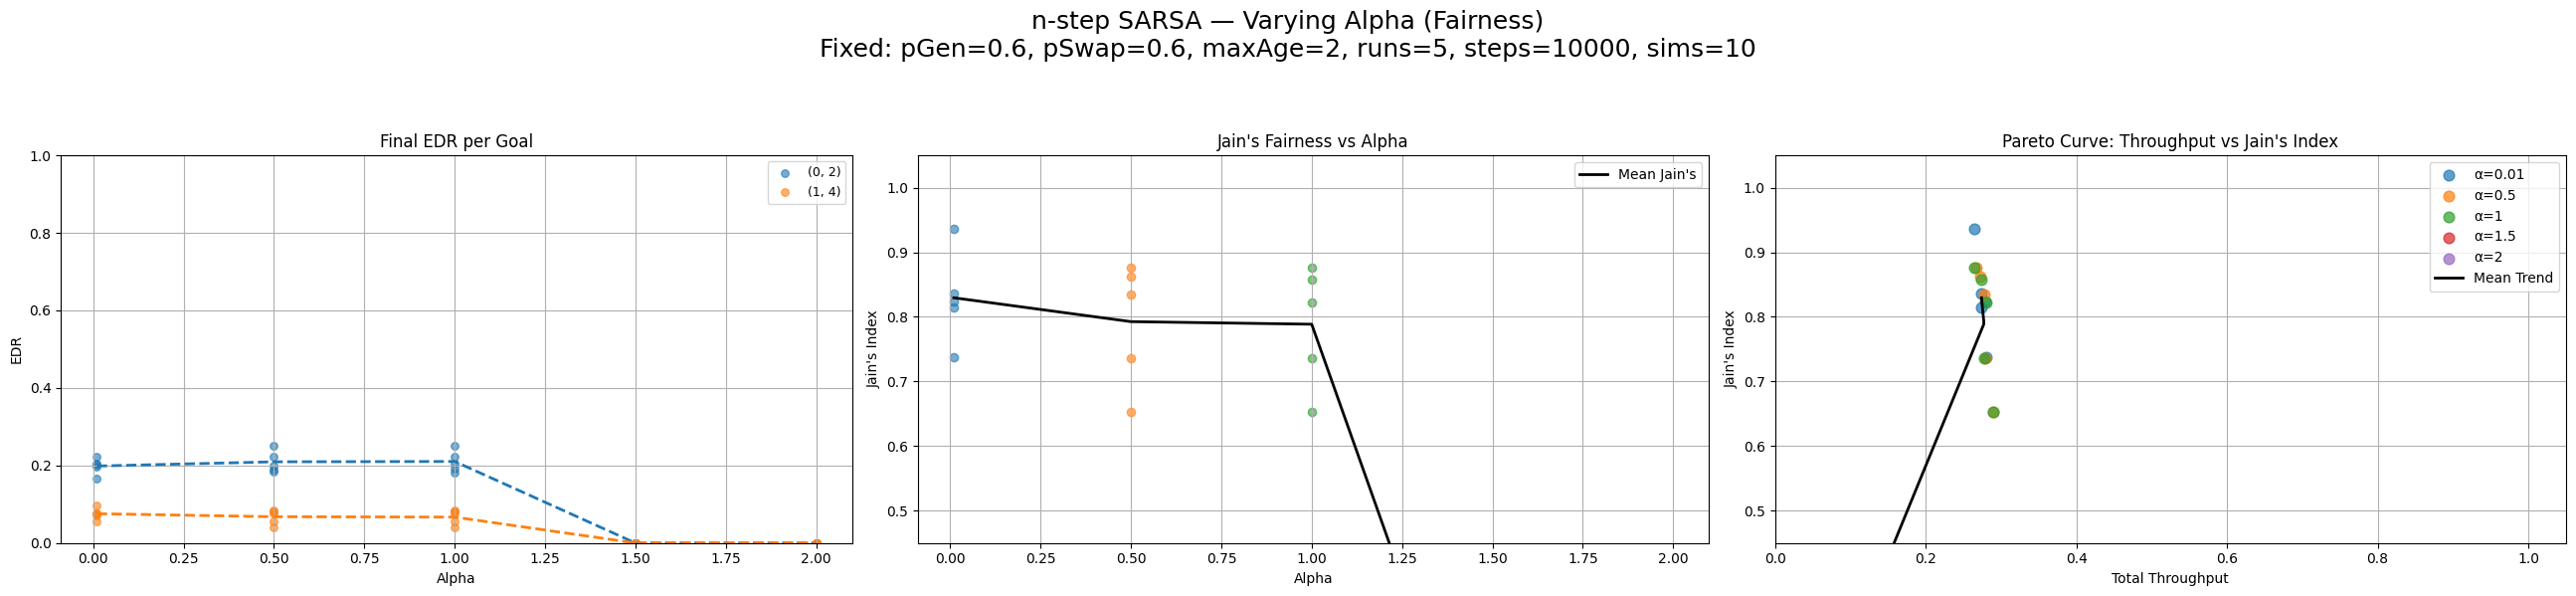

In [ ]:
edges = [(0,1), (1,2), (2,3), (3, 4)]
goalEdges = [(0, 2), (1, 4)]
pSwap = 0.6
pGen = 0.6
maxAge = 2
totalSteps = 4000000
nLookahead = 3
epsilon = 0.05
gamma = 0.995
alpha = 1
edr_window_size=1000
temperature = 5
temperature_decay = 0.995
alpha_vals = [0.01, 0.5, 1, 1.5, 2]



results = compare_policies_across_alpha(
    policy_name="n-step SARSA",
    policy_train_fn=train_sarsa_linear_policy,
    alpha_values=alpha_vals,
    edges=edges,
    goal_edges=goalEdges,
    p_gen=pGen,
    p_swap=pSwap,
    max_age=maxAge,
    train_kwargs={
        "gamma": 0.99,
        "epsilon": 0.05,
        "totalSteps": 10000,
        "nLookahead": 3,  # You can tune this!
        "edr_window_size": 100,
        "reward_mode": "basic",       # or "alpha_fair", "basic"
        "reward_alpha": 1,
        "reward_epsilon": 0.001,
        "softmax": False,
        "temperature": 3.0,
        "temperature_decay": 0.99
    },
    num_runs=5,
    num_steps=10000,
    num_simulations=10,
    plot=True
)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === Setup ===
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goal_edges = [(0, 2), (4, 1)]
maxAge = 2

pGen_values = np.linspace(0.1, 1.0, 10)
pSwap_values = np.linspace(0.1, 1.0, 10)

jains_matrix = np.zeros((len(pSwap_values), len(pGen_values)))
throughput_matrix = np.zeros((len(pSwap_values), len(pGen_values)))

# === Run Experiments Over Grid ===
for i, p_swap in enumerate(pSwap_values):
    for j, p_gen in enumerate(pGen_values):
        print(f"Running: pSwap={p_swap:.2f}, pGen={p_gen:.2f}")

        result = run_policy_experiments(
            train_policy_fn=train_sarsa_linear_policy,  
            policy_name=f"n-step SARSA (pSwap={p_swap:.2f}, pGen={p_gen:.2f})",
            edges=edges,
            goal_edges=goalEdges,
            p_gen=p_gen,
            p_swap=p_swap,
            max_age=maxAge,
            num_runs=3,
            num_steps=5000,
            num_simulations=3,
            train_kwargs={
                "alpha": 0.1,
                "gamma": 0.99,
                "epsilon": 0.1,
                "totalSteps": 8000,
                "nLookahead": 3,
                "temperature": 1.0,
                "temperature_decay": 0.98,
                "softmax": False,
                "reward_mode": "basic",        # optional
                "reward_alpha": 0.5,
                "reward_epsilon": 0.001
            },
            plot=False
        )

        # Make sure you're using the correct goal list name
        jains_matrix[i, j] = np.mean(result["jains"])
        throughput_matrix[i, j] = np.mean([
            sum(result["edrs"][goal][run_i] for goal in goalEdges)  # goalEdges here
            for run_i in range(len(result["jains"]))
        ])


# === Plot Heatmaps ===
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Shared color scale
vmin = min(jains_matrix.min(), throughput_matrix.min())
vmax = max(jains_matrix.max(), throughput_matrix.max())

# Jain's Fairness Heatmap
im1 = axs[0].imshow(jains_matrix, cmap='viridis', origin='lower',
                    extent=[pGen_values[0], pGen_values[-1], pSwap_values[0], pSwap_values[-1]],
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Jain's Fairness Index")
axs[0].set_xlabel("pGen")
axs[0].set_ylabel("pSwap")

# Throughput Heatmap
im2 = axs[1].imshow(throughput_matrix, cmap='viridis', origin='lower',
                    extent=[pGen_values[0], pGen_values[-1], pSwap_values[0], pSwap_values[-1]],
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Total Throughput")
axs[1].set_xlabel("pGen")
axs[1].set_ylabel("pSwap")

# Shared colorbar at the top
cbar_ax = fig.add_axes([0.2, 0.92, 0.6, 0.02])
fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title("Shared Value Scale")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()






In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define network and training parameters
edges = [(0,1), (1,3),(2,3), (3, 4), (4, 5)]
goal_edges = [(0, 5), (2, 4)]

p_swap = 0.6
p_gen = 0.6
max_age = 2
trainingSteps = 300000
nLookahead = 4
epsilon = 0.05
gamma = 0.995
alpha = 0.1
softmax = False
reward_mode = 'basic'
reward_alpha = 1
reward_epsilon = 0.001
edr_window_size = 1000
temperature = 5
temperature_decay = 0.995

seed = 10
random.seed(seed)
np.random.seed(seed)

# === Sweep ranges ===
nLookahead_values = [1, 2, 3, 4, 5, 6, 7, 8]
maxAge_values = [1, 2, 3, 4, 5, 6, 7, 8]

jains_matrix = np.zeros((len(maxAge_values), len(nLookahead_values)))
throughput_matrix = np.zeros((len(maxAge_values), len(nLookahead_values)))

# === Run Experiments Over Grid ===
for i, max_age in enumerate(maxAge_values):
    for j, n_lookahead in enumerate(nLookahead_values):
        print(f"Running: maxAge={max_age}, nLookahead={n_lookahead}")

        result = run_policy_experiments(
            train_policy_fn=train_sarsa_linear_policy,
            policy_name=f"n-step SARSA (maxAge={max_age}, nLookahead={n_lookahead})",
            edges=edges,
            goal_edges=goal_edges,
            p_gen=p_gen,
            p_swap=p_swap,
            max_age=max_age,
            num_runs=3,
            num_steps=10000,
            num_simulations=3,
            train_kwargs={
                "alpha": 0.1,
                "gamma": gamma,
                "epsilon": 0.1,
                "totalSteps": trainingSteps,
                "nLookahead": n_lookahead,
                "temperature": 1.0,
                "temperature_decay": 0.98,
                "softmax": False,
                "reward_mode": "basic",
                "reward_alpha": 1,
                "reward_epsilon": 0.001
            },
            plot=False
        )

        # Store metrics
        jains_matrix[i, j] = np.mean(result["jains"])
        throughput_matrix[i, j] = np.mean([
            sum(result["edrs"][goal][run_i] for goal in goal_edges)
            for run_i in range(len(result["jains"]))
        ])

# === Plot Heatmaps ===
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

vmin = min(jains_matrix.min(), throughput_matrix.min())
vmax = max(jains_matrix.max(), throughput_matrix.max())

# Jain's Fairness Index Heatmap
im1 = axs[0].imshow(jains_matrix, cmap='viridis', origin='lower',
                    extent=[min(nLookahead_values), max(nLookahead_values),
                            min(maxAge_values), max(maxAge_values)],
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Jain's Fairness Index")
axs[0].set_xlabel("n-Lookahead")
axs[0].set_ylabel("maxAge")

# Throughput Heatmap
im2 = axs[1].imshow(throughput_matrix, cmap='viridis', origin='lower',
                    extent=[min(nLookahead_values), max(nLookahead_values),
                            min(maxAge_values), max(maxAge_values)],
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Total Throughput")
axs[1].set_xlabel("n-Lookahead")
axs[1].set_ylabel("maxAge")

# Shared colorbar
cbar_ax = fig.add_axes([0.2, 0.92, 0.6, 0.02])
fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title("Shared Value Scale")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


In [ ]:
# === Plot Heatmaps ===
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

vmin = min(jains_matrix.min(), throughput_matrix.min())
vmax = max(jains_matrix.max(), throughput_matrix.max())

# Jain's Fairness Index Heatmap
im1 = axs[0].imshow(jains_matrix, cmap='viridis', origin='lower',
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Jain's Fairness Index")
axs[0].set_xlabel("n-Lookahead")
axs[0].set_ylabel("maxAge")
axs[0].set_xticks(np.arange(len(nLookahead_values)))
axs[0].set_yticks(np.arange(len(maxAge_values)))
axs[0].set_xticklabels(nLookahead_values)
axs[0].set_yticklabels(maxAge_values)

# Add text annotations
for i in range(len(maxAge_values)):
    for j in range(len(nLookahead_values)):
        axs[0].text(j, i, f"{jains_matrix[i, j]:.2f}",
                    ha='center', va='center', color='white')

# Throughput Heatmap
im2 = axs[1].imshow(throughput_matrix, cmap='viridis', origin='lower',
                    aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Total Throughput")
axs[1].set_xlabel("n-Lookahead")
axs[1].set_ylabel("maxAge")
axs[1].set_xticks(np.arange(len(nLookahead_values)))
axs[1].set_yticks(np.arange(len(maxAge_values)))
axs[1].set_xticklabels(nLookahead_values)
axs[1].set_yticklabels(maxAge_values)

# Add text annotations
for i in range(len(maxAge_values)):
    for j in range(len(nLookahead_values)):
        axs[1].text(j, i, f"{throughput_matrix[i, j]:.1f}",
                    ha='center', va='center', color='white')

# Shared colorbar
cbar_ax = fig.add_axes([0.2, 0.92, 0.6, 0.02])
fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title("Shared Value Scale")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
